# Data Analysis using XGBoost

In [1]:
%pylab inline
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from lib import XGBHelper as xgbh
import pandas as pd
import pickle as pk
from lib.logger import logger
import os 
from glob import glob 
xgb.__version__

Populating the interactive namespace from numpy and matplotlib


'1.5.0'

In [ ]:
dir = '/net/birdstore/Active_Atlas_Data/cell_segmentation/DK55/all_features.csv'
df = pd.read_csv(dir)
drops = ['animal', 'section', 'index', 'row', 'col'] 
df=df.drop(drops,axis=1)

In [ ]:
def createDM(df):
    labels=df['label']
    features=df.drop('label',axis=1)
    return xgb.DMatrix(features, label=labels)

def split_data(df,frac=0.5):
    train = pd.DataFrame(df.sample(frac = frac))
    test = df.drop(train.index,axis=0)
    print(train.shape,test.shape,train.index.shape,df.shape)

    trainDM=createDM(train)
    testDM=createDM(test)
    AllDM=createDM(df)
    return trainDM,testDM,AllDM
trainDM,testDM,allDM=split_data(df)

trainDM.num_row(), testDM.num_row(), allDM.num_row()

(400612, 41) (400611, 41) (400612,) (801223, 41)


(400612, 400611, 801223)

In [ ]:
param = {}
param['max_depth']= 3   # depth of tree
param['eta'] = 0.3      # shrinkage parameter
#param['silent'] = 0     # not silent
param['objective'] = 'binary:logistic'
param['nthread'] = 7 # Number of threads used
param['eval_metric'] = 'logloss' #['error','logloss']

print(param)
evallist = [(trainDM, 'train'), (testDM, 'eval')]

{'max_depth': 3, 'eta': 0.3, 'objective': 'binary:logistic', 'nthread': 7, 'eval_metric': 'logloss'}


## Setting Parameters for XG Boost
* Maximum Depth of the Tree = 3 _(maximum depth of each decision trees)_
* Step size shrinkage used in update to prevents overfitting = 0.3 _(how to weigh trees in subsequent iterations)_
* Maximum Number of Iterations = 1000 _(total number trees for boosting)_
* Early Stop if score on Validation does not improve for 5 iterations

[Full description of options](https://xgboost.readthedocs.io/en/latest//parameter.html)

In [ ]:
# %load lib/Logger.py
import pandas as pd

class logger:
    """A helper class for defining a logger function and for parsing the
log, assuming it is created by XGBoost.
    Typical use:

    Logger=logger()
    logall=Logger.get_logger()

    bst = xgb.train(plst, dtrain, num_round, evallist, verbose_eval=False, callbacks=[logall])
    D=Logger.parse_log() #returns a dataframe with the logs.
    """
    def __init__(self):
        self.log=[]
         
    def get_logger(self):
        def logall(*argv,**argc):
            self.log.append(*argv)
        return logall

    def parse_log(self,ax=None):
        """ parse the log and generate plots"""
        D={'iter':[]}
        for _env in self.log:
            current_err={key:val for key,val in _env.evaluation_result_list}
            D['iter'].append(_env.iteration)
            for k in current_err.keys():
                if k in D:
                    D[k].append(current_err[k])
                else:
                    D[k]=[current_err[k]]
        for k in list(D.keys()):
            if len(D[k])==0:
                del D[k]

        df=pd.DataFrame(D)
        df=df.set_index('iter')
        test_col=[c for c in df.columns if 'eval' in c][0]
        print('test column=',test_col)
        _min=df[test_col].min()
        index_min=df[test_col].idxmin()
        title='min of %s=%f at %d'%(test_col,_min,index_min)
        if not ax is None:
            df.plot(grid=True,title=title,ax=ax)  
        return df


In [ ]:
def test_xgboost(depth=1,num_round=100):
    param['max_depth']= depth   # depth of tree
    fig, axes = subplots(1,2,figsize=(12,5))
    i=0
    for _eval in ['error','logloss']:
        Logger=logger()
        logall=Logger.get_logger()  # Set logger to collect results
        param['eval_metric'] = _eval 
        bst = xgb.train(param, trainDM, num_round, evallist, verbose_eval=False, callbacks=[logall])
        df=Logger.parse_log(ax=axes[i])
        i+=1
    return bst
   

In [ ]:
dir = '/net/birdstore/Active_Atlas_Data/cell_segmentation/DK55/'
index_dict = pk.load(open(dir+'positive_indicies.pkl','rb'))
print(index_dict.keys())
include = ['cells_index','original_index', 'positive_index']#, 'additional_positive_index']
positives = []
for key in include:
    positives += index_dict[key]
labels = np.zeros(len(df))
for i in positives:
    labels[i] = 1
df['label'] = labels
# df = df.dropna()
trainDM,testDM,allDM=split_data(df)
evallist = [(trainDM, 'train'), (testDM, 'eval')]

dict_keys(['cells_index', 'original_index', 'positive_index'])
(400612, 41) (400611, 41) (400612,) (801223, 41)


In [ ]:
test_xgboost(depth=1,num_round=1000)

/usr/local/share/pipeline/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


(400612, 41) (400611, 41) (400612,) (801223, 41)


/usr/local/share/pipeline/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


test column= eval-error


/usr/local/share/pipeline/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


test column= eval-logloss


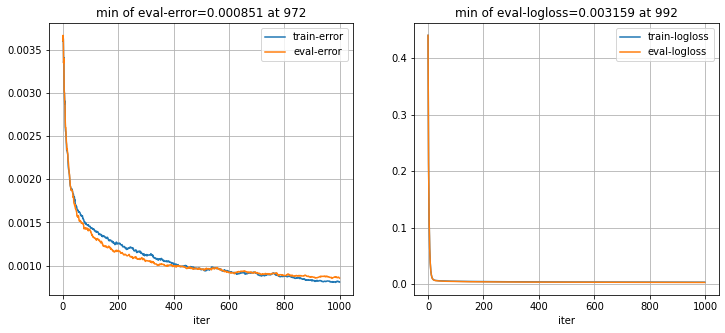

In [ ]:
trainDM,testDM,allDM=split_data(df)
test_xgboost(depth=2,num_round=1000)

/usr/local/share/pipeline/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


test column= eval-error


/usr/local/share/pipeline/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


test column= eval-logloss


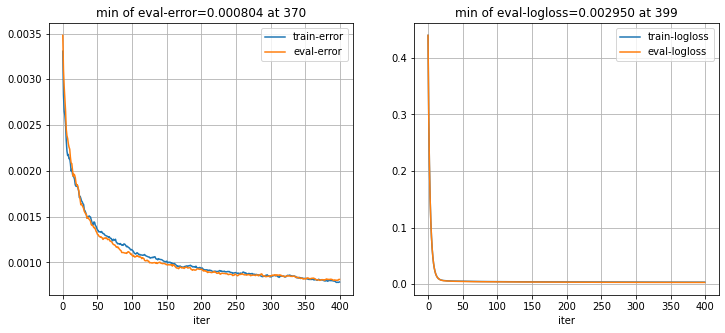

In [ ]:
test_xgboost(depth=3,num_round=400)

/usr/local/share/pipeline/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


test column= eval-error


/usr/local/share/pipeline/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


test column= eval-logloss


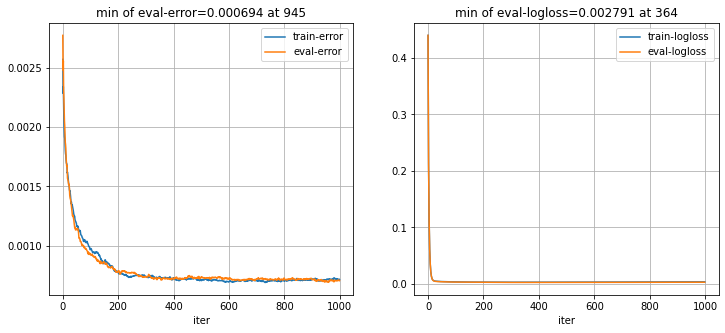

In [ ]:
test_xgboost(depth=4,num_round=1000)

/usr/local/share/pipeline/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


test column= eval-error


/usr/local/share/pipeline/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


test column= eval-logloss


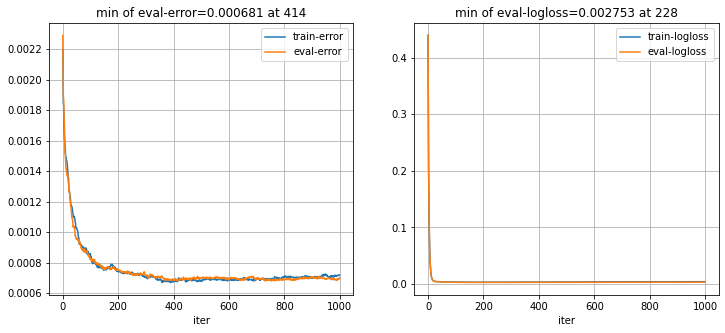

In [ ]:
test_xgboost(depth=5,num_round=1000)

/usr/local/share/pipeline/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


test column= eval-error


/usr/local/share/pipeline/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


test column= eval-logloss


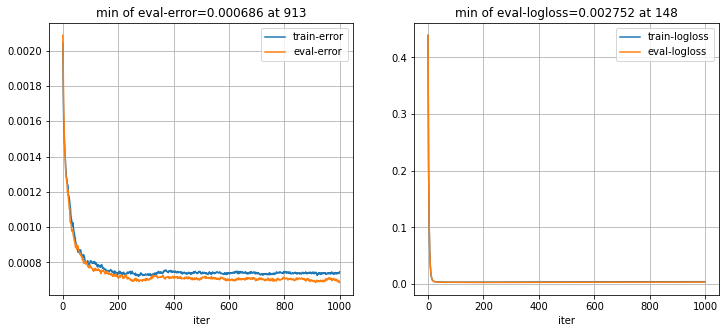

In [ ]:
test_xgboost(depth=6,num_round=1000)

/usr/local/share/pipeline/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


test column= eval-error


/usr/local/share/pipeline/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


test column= eval-logloss


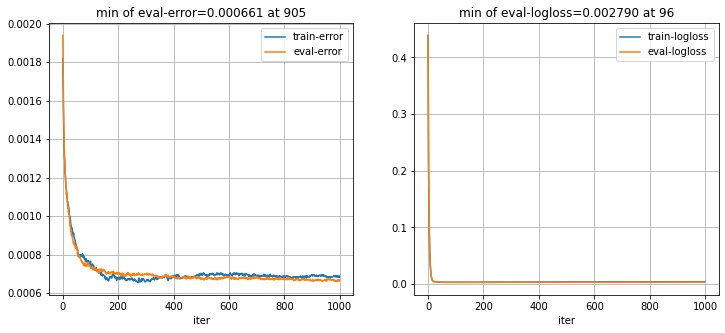

In [ ]:
test_xgboost(depth=7,num_round=1000)

/usr/local/share/pipeline/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


test column= eval-error


/usr/local/share/pipeline/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


test column= eval-logloss


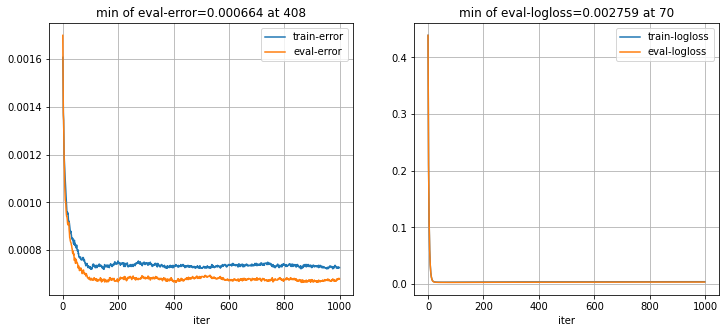

In [ ]:
test_xgboost(depth=9,num_round=1000)

## ROC graph
* Often false positive and false negatives have different cost.
* Different tradeoffs between false positives and false negatives can be gotten using different thresholds.
* The [ROC Curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) is a good way to visualize the tradeoffs. 

In [25]:

param={'max_depth': 4,
 'eta': 0.3,
 'objective': 'binary:logistic',
 'nthread': 7,
 'eval_metric': 'logloss'}
param

{'max_depth': 4,
 'eta': 0.3,
 'objective': 'binary:logistic',
 'nthread': 7,
 'eval_metric': 'logloss'}

In [26]:
num_round=945
bst = xgb.train(param, trainDM, num_round, evallist, verbose_eval=False)
y_pred = bst.predict(testDM, iteration_range=[1,bst.best_ntree_limit], output_margin=True)
y_pred.shape



(400611,)

In [27]:
y_test=testDM.get_label()

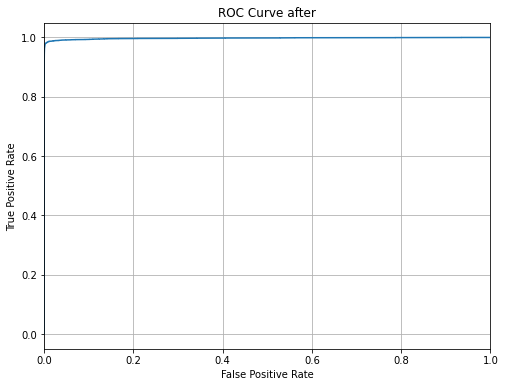

In [28]:
from sklearn.metrics import roc_curve

plt.figure(figsize=(8, 6))
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
#plt.plot(fpr, tpr)
#fpr, tpr, thresholds = roc_curve(y_test, y_pred_1000)
plt.plot(fpr, tpr)
plt.xlim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve after")
plt.grid()
plt.show()

## Stability of the Margins.
Margins on the training set are predictive of margins of the test set, which is why margins are a better measure of performance than the training error.

In [29]:
y_test=testDM.get_label()
pos_preds=y_pred[y_test==1]
neg_preds=y_pred[y_test==0]
pos_preds.shape,neg_preds.shape

((6358,), (394253,))

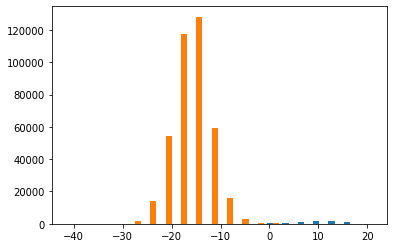

In [30]:
hist([pos_preds,neg_preds],bins=20);

In [31]:
def gen_scale(n,reverse=False):
    s=arange(0,1,1/n)
    while s.shape[0] !=n:
        if s.shape[0]>n:
            s=s[:n]
        if s.shape[0]<n:
            s=arange(0,1,1/(n+0.1))
    if reverse:
        s=s[-1::-1]
    return s

(400612, 41) (400611, 41) (400612,) (801223, 41)
(400612, 41) (400611, 41) (400612,) (801223, 41)
(400612, 41) (400611, 41) (400612,) (801223, 41)
(400612, 41) (400611, 41) (400612,) (801223, 41)
(400612, 41) (400611, 41) (400612,) (801223, 41)
(400612, 41) (400611, 41) (400612,) (801223, 41)
(400612, 41) (400611, 41) (400612,) (801223, 41)
(400612, 41) (400611, 41) (400612,) (801223, 41)
(400612, 41) (400611, 41) (400612,) (801223, 41)
(400612, 41) (400611, 41) (400612,) (801223, 41)
(400612, 41) (400611, 41) (400612,) (801223, 41)
(400612, 41) (400611, 41) (400612,) (801223, 41)
(400612, 41) (400611, 41) (400612,) (801223, 41)
(400612, 41) (400611, 41) (400612,) (801223, 41)
(400612, 41) (400611, 41) (400612,) (801223, 41)
(400612, 41) (400611, 41) (400612,) (801223, 41)
(400612, 41) (400611, 41) (400612,) (801223, 41)
(400612, 41) (400611, 41) (400612,) (801223, 41)
(400612, 41) (400611, 41) (400612,) (801223, 41)
(400612, 41) (400611, 41) (400612,) (801223, 41)
(400612, 41) (400611

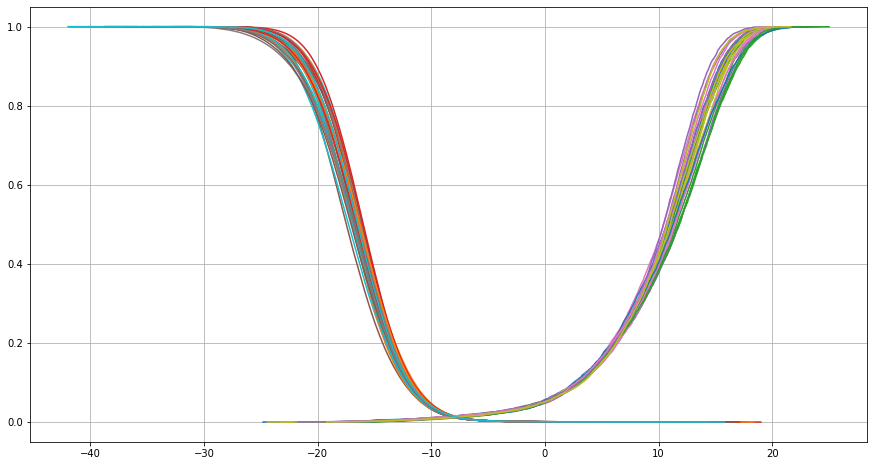

In [32]:
figure(figsize=[15,8])
num_round=945
bst_list=[]
for i in range(30):
    trainDM,testDM,allDM=split_data(df)
    bst = xgb.train(param, trainDM, num_round, evallist, verbose_eval=False)
    bst_list.append(bst)
    y_pred = bst.predict(testDM, iteration_range=[1,bst.best_ntree_limit], output_margin=True)
    y_test=testDM.get_label()
    pos_preds=y_pred[y_test==1]
    neg_preds=y_pred[y_test==0]
    pos_preds=sort(pos_preds)
    neg_preds=sort(neg_preds)
    plot(pos_preds,gen_scale(pos_preds.shape[0]));
    plot(neg_preds,gen_scale(neg_preds.shape[0],reverse=True))
grid();

In [33]:
DATA_DIR='/net/birdstore/Active_Atlas_Data/cell_segmentation/'
DATA_DIR

'/net/birdstore/Active_Atlas_Data/cell_segmentation/'

In [34]:
import pickle as pk
with open(DATA_DIR+'BoostedTrees_new.pkl','bw') as pkl_file:
    pk.dump(bst_list,pkl_file)
!ls -lh $DATA_DIR/*.pkl

-rw-r--r-- 1 zhw272 birdstore  47M Feb 11 14:22 /net/birdstore/Active_Atlas_Data/cell_segmentation//BoostedTrees_new.pkl
-rw-r--r-- 1 zhw272 birdstore 7.0M Nov 16 17:51 /net/birdstore/Active_Atlas_Data/cell_segmentation//BoostedTrees.pkl


### Skip to here for testing without training

In [38]:
import pickle as pk
with open(DATA_DIR+'BoostedTrees_new.pkl','br') as pkl_file:
    bst_list=pk.load(pkl_file)

In [39]:
trainDM,testDM,AllDM=split_data(df)
labels=AllDM.get_label()
scores=np.zeros([df.shape[0],len(bst_list)])
for i in range(len(bst_list)):
    bst=bst_list[i]
    scores[:,i] = bst.predict(AllDM, iteration_range=[1,bst.best_ntree_limit], output_margin=True)

 

(400612, 41) (400611, 41) (400612,) (801223, 41)


In [40]:
_max=np.max(scores,axis=1)
_min=np.min(scores,axis=1)

_mean=np.mean(scores,axis=1)
_std=np.std(scores,axis=1)

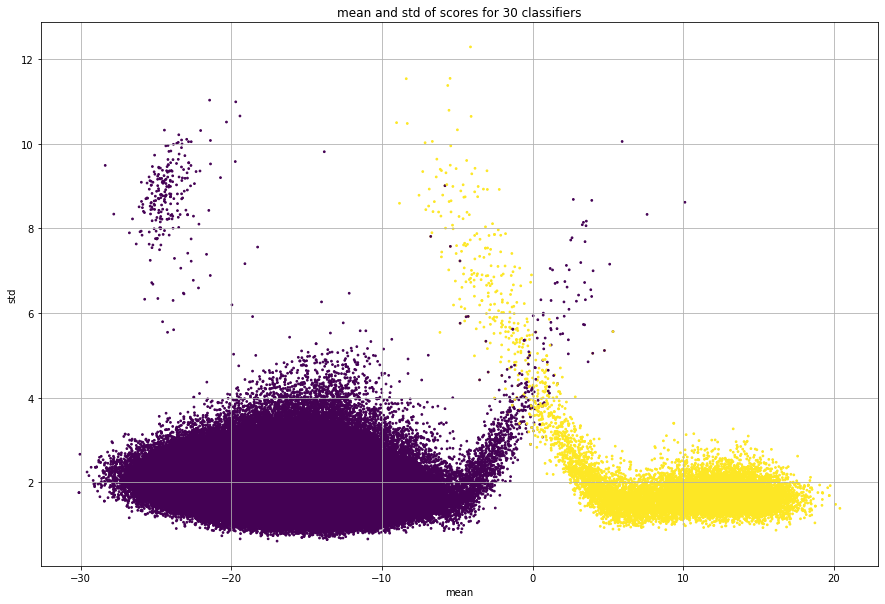

In [41]:
figure(figsize=[15,10])
scatter(_mean,_std,c=labels,s=3)

title('mean and std of scores for 30 classifiers')
xlabel('mean')
ylabel('std')
grid()

In [43]:
from DefinePredictor import *

In [46]:
df['mean_score']=_mean
df['std_score']=_std

In [66]:
def points2line(p1,p2,i):
    x1,y1=p1
    x2,y2=p2
    a=(y1-y2)/(x1-x2)
    b=y1-a*x1
    #plotline(a,b,i)
    return a,b

p=[[0,2.5],[3,4.5],[1,6],[-3,4],[-10,7],[10,7]]
def plotline(a,b,i):
    X=arange(-5,5,0.01)
    Y=a*X+b
    plot(X,Y,label=str(i))
    
def aboveline(p,l):
    return l[0]*p[0]+l[1] < p[1]

L=[]
L.append(points2line(p[0],p[1],0))
L.append(points2line(p[1],p[2],1))
L.append(points2line(p[2],p[3],2))
L.append(points2line(p[3],p[0],3))
L.append(points2line(p[1],p[5],4))
L.append(points2line(p[3],p[4],5))

def decision(x,y):
    p=[x,y]
    if aboveline(p,L[0]) and not aboveline(p,L[1])\
    and not aboveline(p,L[2]) and aboveline(p,L[3]):
        return 0
    if (x<0 and not aboveline(p,L[5])) or (x>0 and aboveline(p,L[4])):
        return -2
    if (x>0 and not aboveline(p,L[4])) or (x<0 and aboveline(p,L[5])):
        return 2


In [63]:
predictions=[]
for i,row in df.iterrows():
    p=decision(float(row['mean_score']),float(row['std_score']))
    predictions.append(p)
df['predictions']=predictions

In [48]:
df.to_csv(DATA_DIR+'demo_scores.csv')

In [39]:
df.columns

Index(['animal', 'section', 'index', 'label', 'area', 'height', 'width', 'row',
       'col', 'corr_CH1', 'energy_CH1', 'corr_CH3', 'energy_CH3', 'm00CH_3',
       'm10CH_3', 'm01CH_3', 'm20CH_3', 'm11CH_3', 'm02CH_3', 'm30CH_3',
       'm21CH_3', 'm12CH_3', 'm03CH_3', 'mu20CH_3', 'mu11CH_3', 'mu02CH_3',
       'mu30CH_3', 'mu21CH_3', 'mu12CH_3', 'mu03CH_3', 'nu20CH_3', 'nu11CH_3',
       'nu02CH_3', 'nu30CH_3', 'nu21CH_3', 'nu12CH_3', 'nu03CH_3', 'h0_CH_3',
       'h1_CH_3', 'h2_CH_3', 'h3_CH_3', 'h4_CH_3', 'h5_CH_3', 'h6_CH_3',
       'contrast1', 'contrast3', 'mean_score', 'std_score', 'predictions'],
      dtype='object')

In [74]:
dir = '/net/birdstore/Active_Atlas_Data/cell_segmentation/DK55/all_features.csv'
full_df = pd.read_csv(dir)
full_df['predictions'] = predictions
full_df['mean_score']=_mean
full_df['std_score']=_std

In [75]:
detection_df=full_df[full_df['predictions']!=-2]
detection_df = detection_df[['animal', 'section', 'row', 'col','label', 'mean_score',
       'std_score', 'predictions']]
detection_df.head()

,animal,section,row,col,label,mean_score,std_score,predictions
28,DK55,132,18851,37633,0,2.300336,2.641531,2
74,DK55,145,17423,38133,0,13.614603,1.690921,2
98,DK55,145,17638,37839,0,6.491115,1.971473,2
111,DK55,145,17708,37724,0,14.793945,1.715106,2
127,DK55,145,17794,37634,0,12.054438,2.028603,2


In [77]:
DATA_DIR

'/net/birdstore/Active_Atlas_Data/cell_segmentation/'

In [76]:
detection_df.to_csv(DATA_DIR+'detections_DK55_new.csv',index=False)

In [50]:
from collections import Counter
Counter(predictions)

Counter({-2: 788321, 2: 12789, 0: 113})

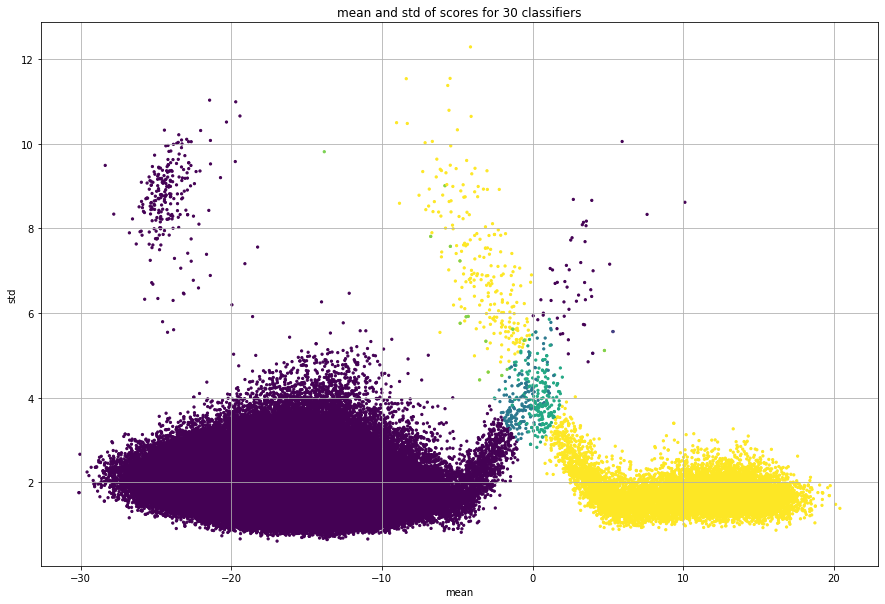

In [64]:
figure(figsize=[15,10])
scatter(_mean,_std,c=predictions+labels,s=5)

title('mean and std of scores for 30 classifiers')
xlabel('mean')
ylabel('std')
grid()